In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd


### Training Stats

In [3]:
training_stats_paths = [
    'training_stats/GAT_2025-06-05_15-51-27_train_stats_100epochs.npz',
    'training_stats/GCN_2025-06-05_16-41-13_train_stats_100epochs.npz'
]

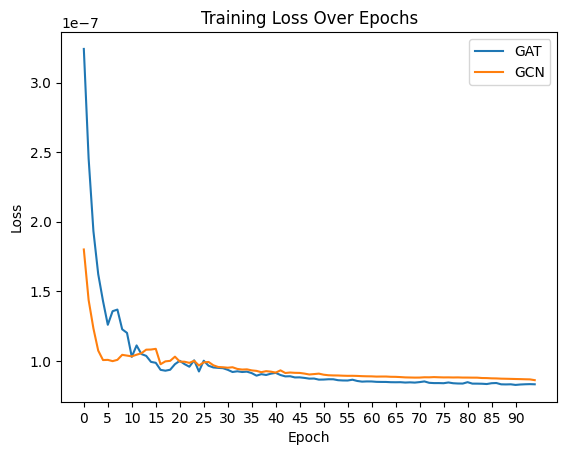

In [4]:
def plot_training_loss_for_all_models(stats_paths: list[str], start_epoch: int = 0):
    for i, path in enumerate(stats_paths):
        label = path.split('/')[-1].split('_')[0]
        train_loss = np.load(path, allow_pickle=True)['train_epoch_loss']
        train_loss = train_loss[start_epoch:]
        plt.plot(train_loss, label=label)

    plt.title('Training Loss Over Epochs')
    plt.xticks(np.arange(len(train_loss), step=5))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_training_loss_for_all_models(training_stats_paths, start_epoch=5)

### Overall Metric Comparison

In [5]:
RUN_ID = 15 # 13, 14, 15, 16

metric_paths = [
    f'saved_metrics/gat_100epochs/GAT_2025-06-05_15-51-27_100epochs_runid_{RUN_ID}_test_metrics.npz',
    f'saved_metrics/gcn_100epochs/GCN_2025-06-05_16-41-13_100epochs_runid_{RUN_ID}_test_metrics.npz',
]

In [6]:
# Double check targets are the same
EPS = 1e-5
comparison_target = None
for path in metric_paths:
    print('Checking target for', path)
    target = np.load(path, allow_pickle=True)['target']
    if comparison_target is None:
        comparison_target = target
    else:
        assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'

Checking target for saved_metrics/gat_100epochs/GAT_2025-06-05_15-51-27_100epochs_runid_15_test_metrics.npz
Checking target for saved_metrics/gcn_100epochs/GCN_2025-06-05_16-41-13_100epochs_runid_15_test_metrics.npz


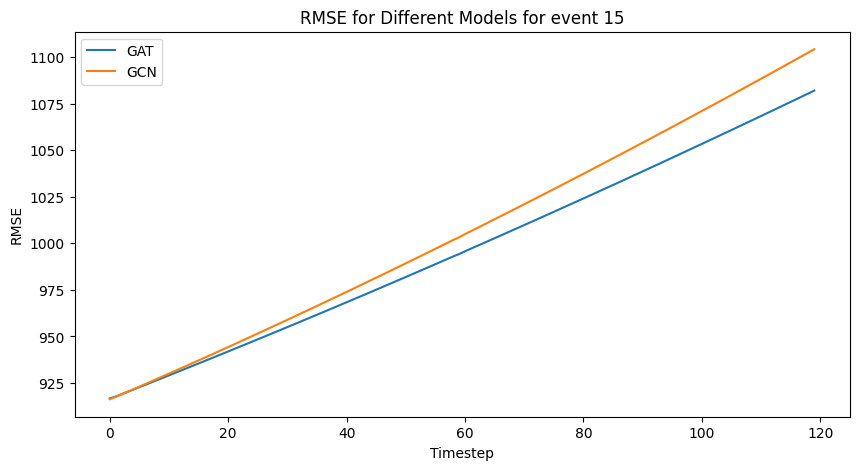

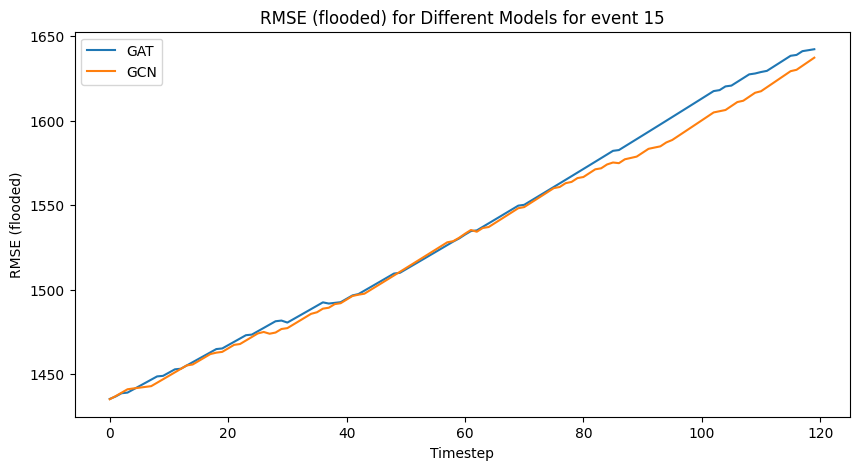

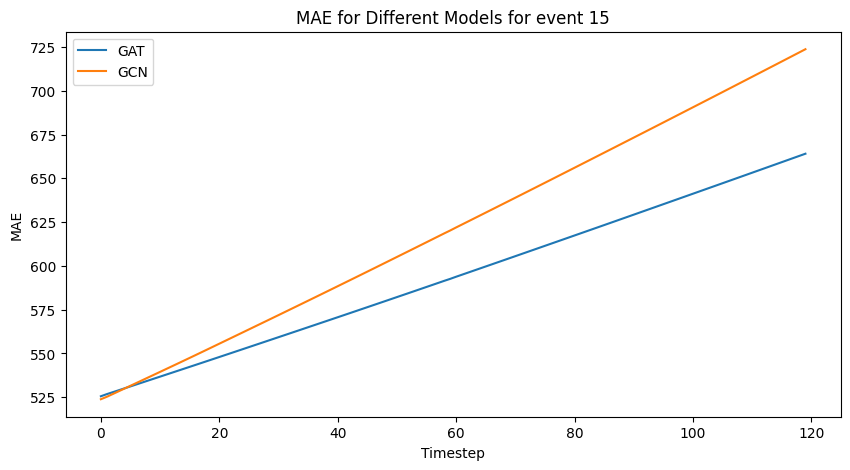

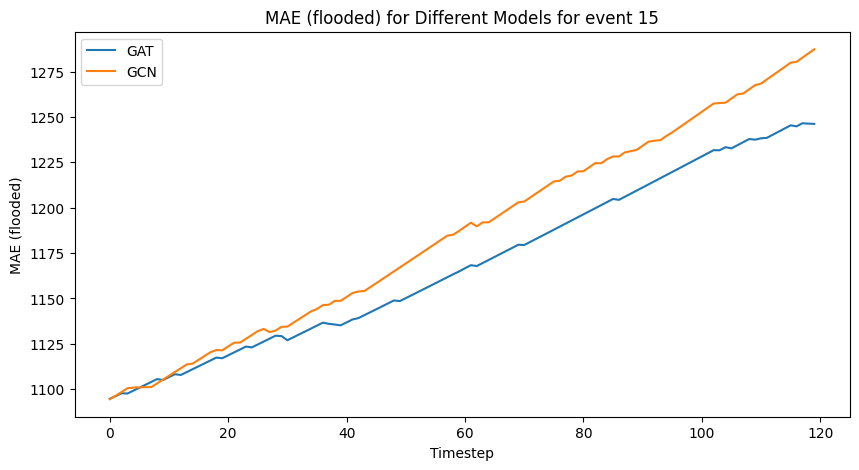

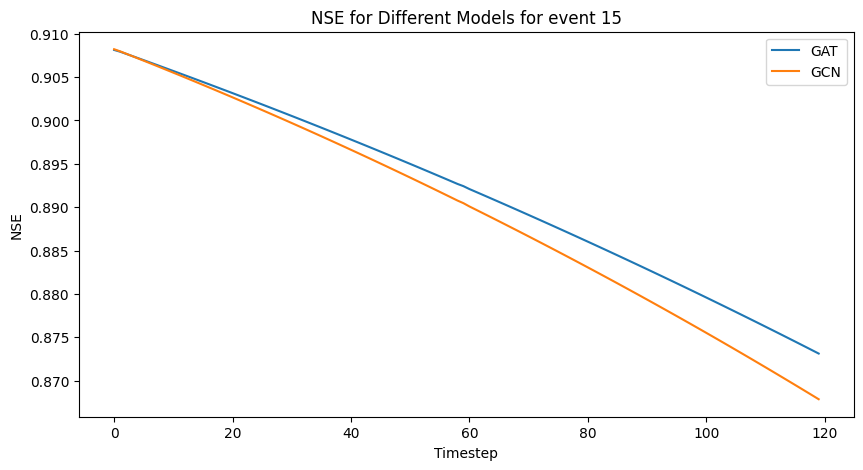

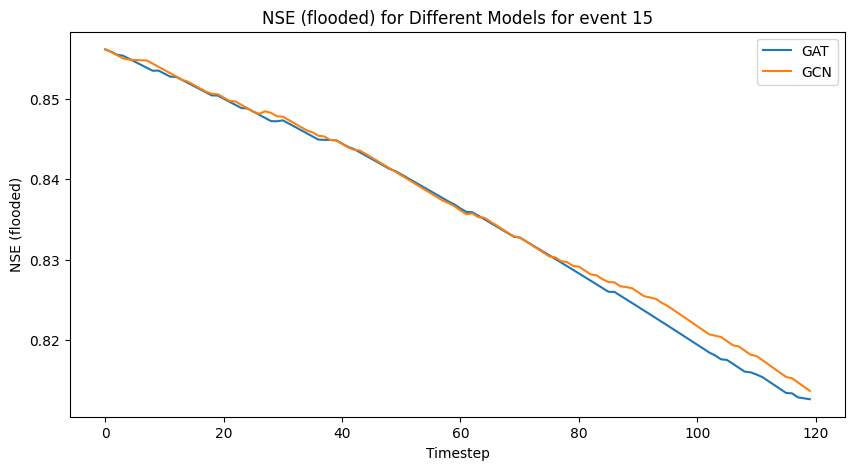

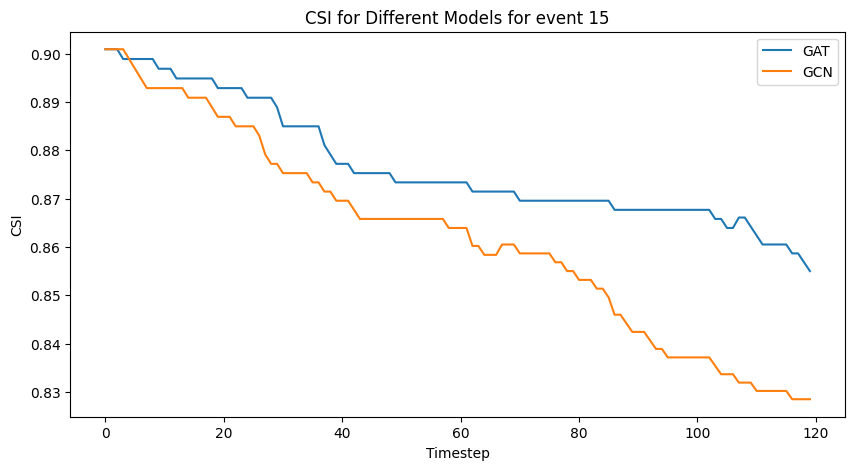

In [7]:
def plot_metric_for_all_models(metric_paths: list[str], metric: str, labels: list[str] = None):
    split_metric = metric.split('_') 
    metric_name = split_metric[0].upper() + (f' ({split_metric[1]})' if len(split_metric) > 1 else '')
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))
    plt.title(f'{metric_name} for Different Models for event {event_name}')
    plt.xlabel('Timestep')
    plt.ylabel(metric_name)

    data_shape = None
    for i, path in enumerate(metric_paths):
        label = path.split('/')[-1].split('_')[0]
        data = np.load(path, allow_pickle=True)[metric]
        # print(f'Average {metric_name} for {label}: {np.mean(data):.4f}')
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for model {label}: {data.shape} vs {data_shape}"

        if len(path.split('/')[-1].split('_')) == 4:
            label = f'{label} ({path.split('/')[-1].split('_')[3]})'

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(data, label=label)

    plt.legend()
    plt.show()

# labels=None
labels = ['GAT', 'GCN']
metrics = ['rmse', 'rmse_flooded', 'mae', 'mae_flooded', 'nse', 'nse_flooded', 'csi']
for metric in metrics:
    plot_metric_for_all_models(metric_paths, metric, labels=labels)

(Run ID 15) Peak water depth for node 1022: 13607.658203125 (timestep 119)


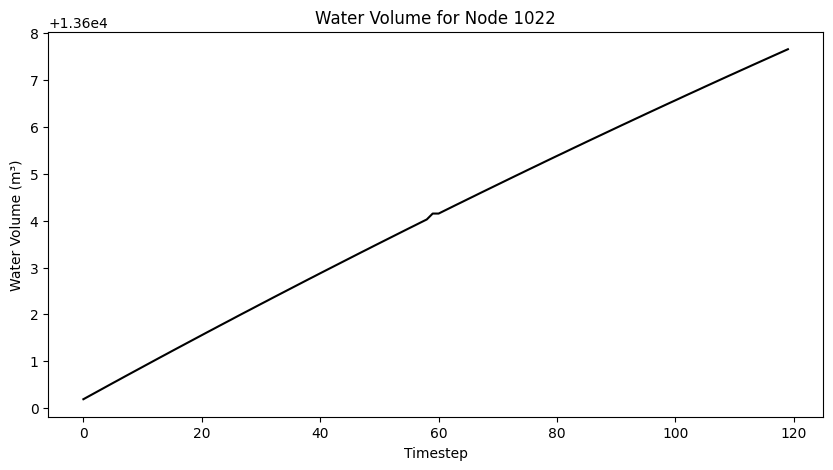

(Run ID 15) Peak water depth for node 1026: 3057.22314453125 (timestep 119)


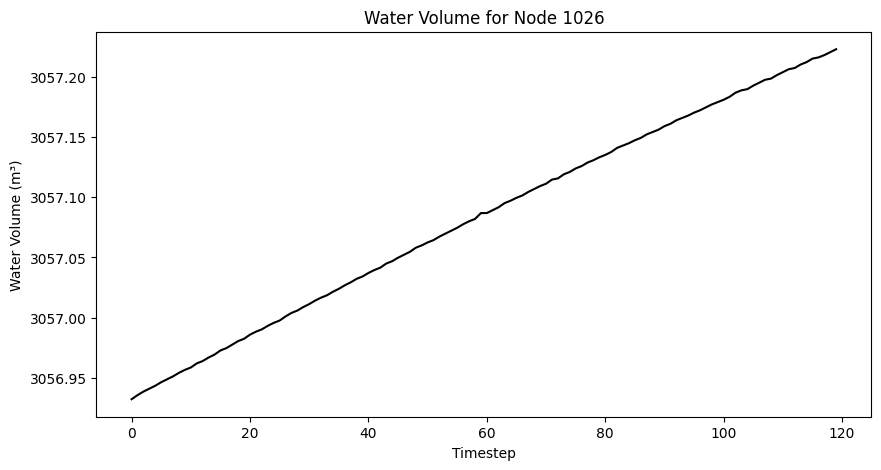

(Run ID 15) Peak water depth for node 1023: 765.927734375 (timestep 119)


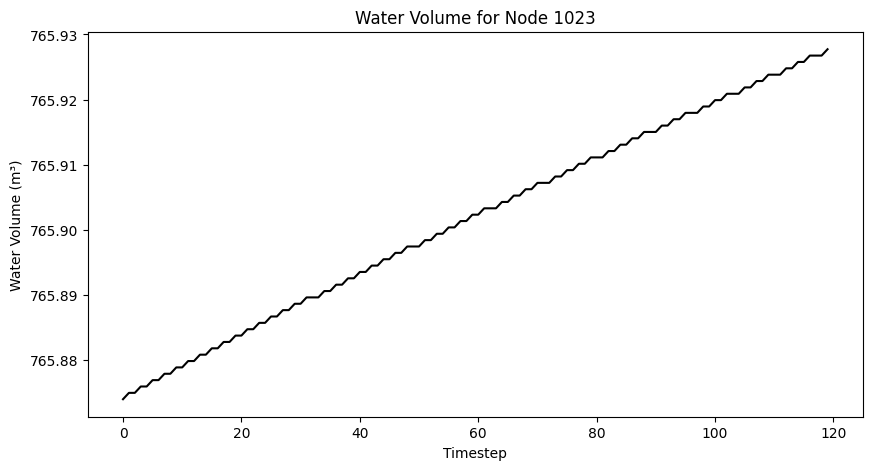

(Run ID 15) Peak water depth for node 1082: 731.4443359375 (timestep 98)


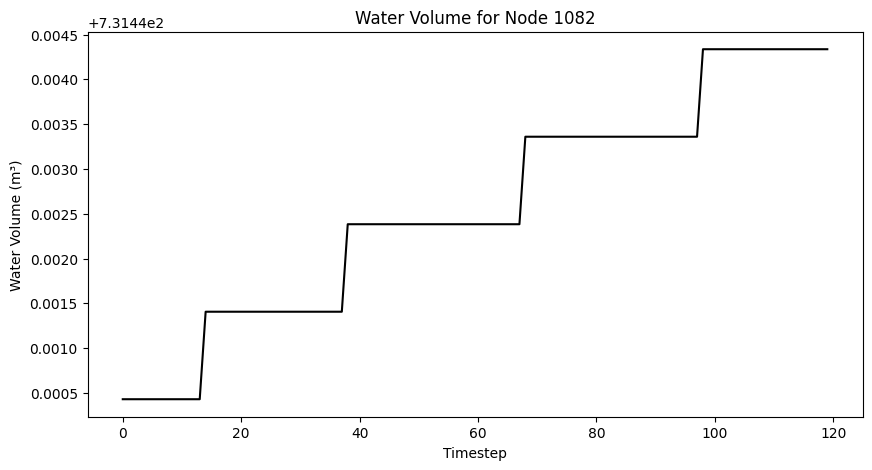

In [8]:
# Top 4 highest water differences
NODE_IDX_MAP = {
    13: [500, 1023, 576, 782], # Run ID 13
    14: [576, 443, 1026, 459],
    15: [1022, 1026, 1023, 1082],
    16: [1022, 1023, 1026, 1082],
}
node_idxs = NODE_IDX_MAP[RUN_ID]

def plot_water_volume_for_node(node_idx: int, water_volume: np.ndarray, num_timesteps: int = None):
    if num_timesteps is None:
        num_timesteps = water_volume.shape[0]

    plt.figure(figsize=(10, 5))
    plt.title(f'Water Volume for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Volume (m³)')
    plt.plot(water_volume[:num_timesteps, node_idx], color='black')
    plt.show()

ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']

for node_idx in node_idxs:
    peak_wv = ground_truth[:, node_idx].max()
    peak_wv_timestep = ground_truth[:, node_idx].argmax()
    print(f"(Run ID {RUN_ID}) Peak water depth for node {node_idx}: {peak_wv} (timestep {peak_wv_timestep})")

    plot_water_volume_for_node(node_idx, ground_truth)

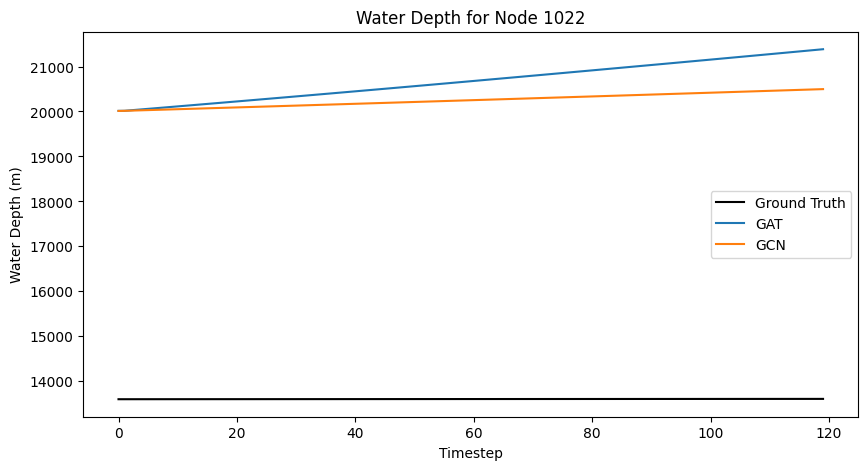

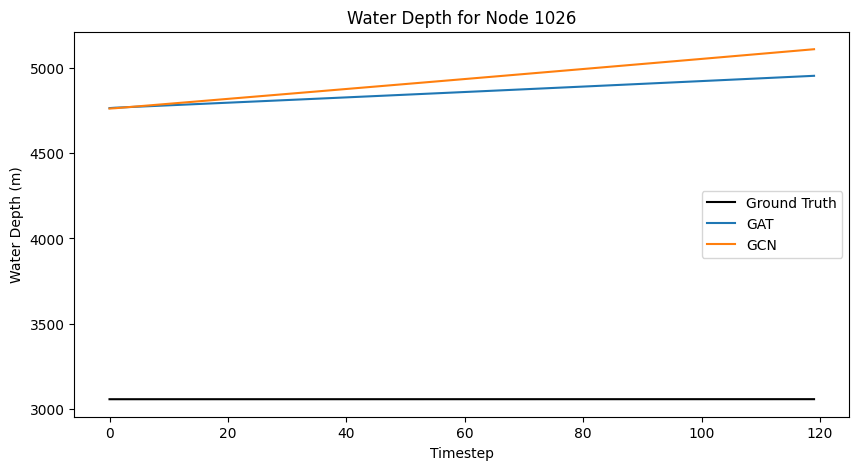

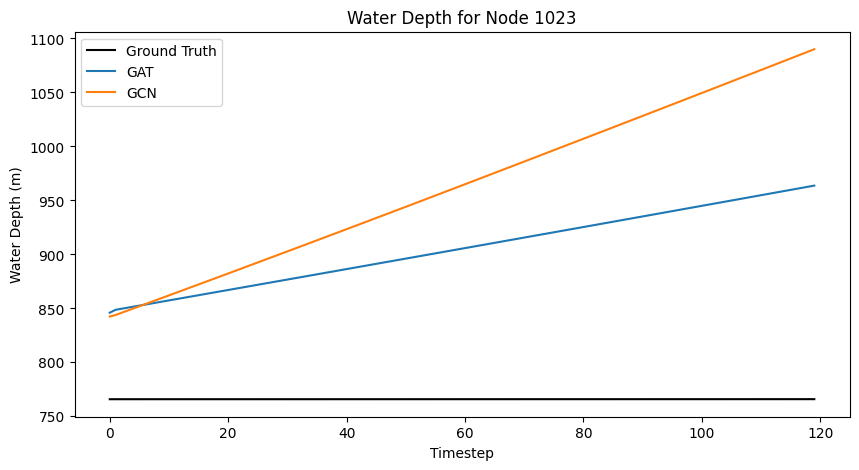

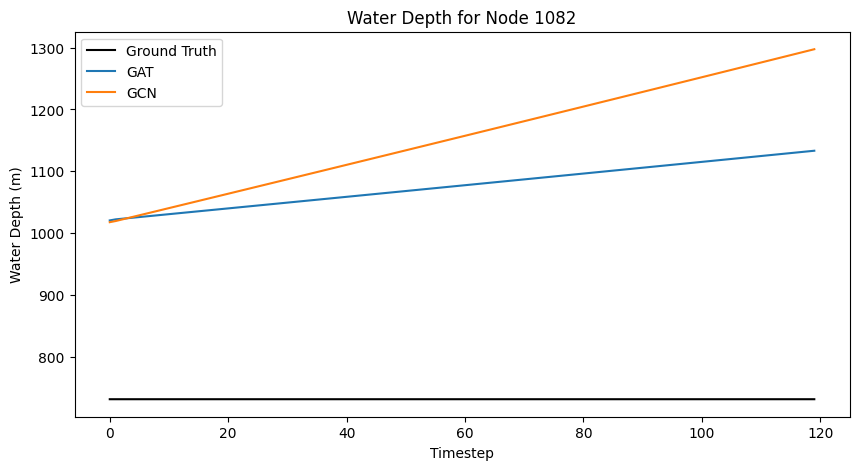

In [10]:
def plot_node_water_depth_for_all_models(metric_paths: list[str], node_idx: int, ground_truth: np.ndarray = None, labels: list[str] = None):
    plt.figure(figsize=(10, 5))
    plt.title(f'Water Depth for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Depth (m)')

    if ground_truth is not None:
        plt.plot(ground_truth[:, node_idx], label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch for path {path}: {pred.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(pred[:, node_idx], label=label)

    plt.legend()
    plt.show()

for node_idx in node_idxs:
    plot_node_water_depth_for_all_models(metric_paths, node_idx, ground_truth=ground_truth, labels=labels)

In [ ]:
# def convert_water_depth_to_binary(water_depth: np.ndarray, water_threshold: float = 0.3) -> np.ndarray:
#     is_flooded_int = (water_depth > water_threshold).astype(int)
#     is_flooded_str = pd.cut(is_flooded_int, bins=[-1, 0, 1], labels=['Not Flooded', 'Flooded'])
#     return is_flooded_str

# def plot_cell_map(axis, node_df: gpd.GeoDataFrame, value: np.ndarray, title: str):
#     value_column = 'is_flooded'
#     cmap = plt.get_cmap('seismic_r') 
#     shared_plot_kwargs = {
#         'cmap': cmap,
#         'column': value_column,
#         'linewidth': 0.3,
#         'markersize': 0.5,
#         'legend': True,
#         'legend_kwds': {
#             'loc': 'upper right',
#             'fontsize': 'x-small',
#         },
#     }
#     node_df[value_column] = value

#     node_df.plot(ax=axis, **shared_plot_kwargs)
#     axis.set_title(title)
#     axis.set_axis_off()

# def plot_flooded_areas_for_all_models(node_df: gpd.GeoDataFrame, metric_paths: list[str], timestep: int, ground_truth: torch.Tensor = None, water_threshold: float = 0.3, labels: list[str] = None):
#     event_name = metric_paths[0].split('/')[-1].split('_')[1]
#     ncols = 3
#     num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
#     nrows = (num_plots + ncols - 1) // ncols
#     assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

#     fig, ax = plt.subplots(figsize=(12,8), ncols=ncols, nrows=nrows)
#     fig.suptitle(f'Flooded Areas for Timestep {timestep} in event {event_name}')
#     index = 0

#     if ground_truth is not None:
#         binary_gt = convert_water_depth_to_binary(ground_truth[timestep, :, :].squeeze(), water_threshold)
#         ax_row = index // ncols
#         ax_col = index % ncols
#         plot_cell_map(ax[ax_row, ax_col], node_df, binary_gt, title='Ground Truth')
#         index += 1

#     data_shape = None
#     for i, path in enumerate(metric_paths):
#         pred = np.load(path, allow_pickle=True)['pred']
#         if data_shape is None:
#             data_shape = pred.shape
#         assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

#         binary_pred = convert_water_depth_to_binary(pred[timestep, :, :].squeeze(), water_threshold)
#         title = path.split('/')[-1].split('_')[0]

#         if labels is not None:
#             title = labels[i] if i < len(labels) else title

#         ax_row = index // ncols
#         ax_col = index % ncols
#         plot_cell_map(ax[ax_row, ax_col], node_df, binary_pred, title=title)
#         index += 1

#     while index < (nrows * ncols):
#         ax_row = index // ncols
#         ax_col = index % ncols
#         ax[ax_row, ax_col].axis('off')
#         index += 1

#     plt.show()

# TIMESTEP = 0
# ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
# plot_flooded_areas_for_all_models(node_df, metric_paths, timestep=TIMESTEP, ground_truth=ground_truth, water_threshold=0.05, labels=labels)